# Predicting Football Player Positions Using Performance Statistics from Top 5 European Leagues (2023–2024)

## Overview
This notebook demonstrates how to build a machine learning model to predict football player positions based on their performance statistics. The dataset contains player statistics from the top 5 European leagues for the 2023-2024 season.

## Table of Contents
1. [Data Loading and Exploration](#1-data-loading-and-exploration)
2. [Data Preprocessing](#2-data-preprocessing)
3. [Exploratory Data Analysis](#3-exploratory-data-analysis)
4. [Feature Engineering and Model Preparation](#4-feature-engineering-and-model-preparation)
5. [Model Training and Cross-Validation](#5-model-training-and-cross-validation)
6. [Model Evaluation](#6-model-evaluation)
7. [Classification Report Visualization](#7-classification-report-visualization)
8. [ROC-AUC Curves](#8-roc-auc-curves)
9. [Feature Importance Analysis](#9-feature-importance-analysis)
10. [Model Serialization](#10-model-serialization)
11. [Model Performance Summary](#11-model-performance-summary)
12. [Conclusion](#12-conclusion-and-key-findings)


## Libraries and Setup


In [66]:
# Import all necessary libraries

# Data manipulation and analysis
import pandas as pd  # For data manipulation and analysis

# Data visualization
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
import seaborn as sns  # For statistical data visualization based on matplotlib

# File operations and serialization
import pathlib  # For object-oriented filesystem paths

# Model selection and evaluation
from sklearn.metrics import classification_report     # For detailed classification metrics


# Import functions from model_pipeline.py
import importlib
import model_pipeline
importlib.reload(model_pipeline)

from model_pipeline import (
    load_data, explore_data, preprocess_data,
    plot_position_distribution, plot_correlation_heatmap,
    prepare_features_and_target, create_train_test_split, create_preprocessor,
    cross_validate_models, train_best_model, evaluate_model,
    save_evaluation_results, plot_confusion_matrix, plot_classification_report, 
    plot_roc_curves, plot_feature_importance,
    save_model, run_full_pipeline
)

# Set plot style for better visualization
sns.set_style("whitegrid")

# Create artifacts directory for saving model outputs and visualizations
pathlib.Path("artifacts").mkdir(exist_ok=True)


## 1. Data Loading and Exploration
Load the dataset and explore its basic properties.

### Purpose of This Section:
- **Data Understanding**: Get familiar with the structure and content of our dataset
- **Initial Assessment**: Check data types, missing values, and basic statistics
- **Target Distribution**: Examine the distribution of player positions (our target variable)
- **Data Quality**: Identify potential issues that might need addressing in preprocessing

### What We're Looking For:
- **Dataset Size**: Number of players and features available for analysis
- **Feature Types**: Numerical statistics vs. categorical information
- **Position Distribution**: How many players in each position category
- **Potential Challenges**: Class imbalance, missing data, or unusual values

This initial exploration helps us understand what we're working with and informs our preprocessing decisions.


In [67]:
# Load the data using the function from model_pipeline.py
df = load_data('data/top5-players.csv')

# Explore the data
exploration_results = explore_data(df)

# Display column names
print("\nColumn names:")
print(exploration_results['columns'])

# Display the first five rows
print("\nFirst five rows:")
print(exploration_results['sample_data'])

# Show distribution of primary positions
print("\nDistribution of primary positions:")
print(exploration_results['primary_position_counts'])
print(f"Number of unique primary positions: {exploration_results['unique_primary_positions']}")


Loading data from data/top5-players.csv...
Dataset shape: (2852, 37) (rows, columns)

Column names:
['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls_90', 'Ast_90', 'G+A_90', 'G-PK_90', 'G+A-PK_90', 'xG_90', 'xAG_90', 'xG+xAG_90', 'npxG_90', 'npxG+xAG_90', 'Primary_Position']

First five rows:
   Rk             Player   Nation    Pos           Squad                Comp  \
0   1         Max Aarons  eng ENG     DF     Bournemouth  eng Premier League   
1   2   Brenden Aaronson   us USA  MF,FW    Union Berlin       de Bundesliga   
2   3    Paxten Aaronson   us USA     MF  Eint Frankfurt       de Bundesliga   
3   4  Keyliane Abdallah   fr FRA     FW       Marseille          fr Ligue 1   
4   5   Yunis Abdelhamid   ma MAR     DF           Reims          fr Ligue 1   

    Age    Born  MP  Starts  ...  Ast_90  G+A_90  G-PK_9

## 2. Data Preprocessing
Clean and prepare the data for modeling.

### Key Preprocessing Steps:
1. **Handling Missing Values**: Removing rows with missing position data and imputing other missing values
2. **Feature Extraction**: Creating a 'Primary_Position' feature from the 'Pos' column
3. **Removing Identifiers**: Dropping columns that don't contribute to prediction (e.g., player names)
4. **Data Cleaning**: Ensuring data consistency and quality

### Why Preprocessing is Critical:
- **Data Quality**: Machine learning models require clean, consistent data
- **Feature Relevance**: Not all available data is useful for prediction
- **Missing Data Strategy**: How we handle missing values affects model performance
- **Target Definition**: Clearly defining what we're trying to predict (primary position)

The preprocessing steps ensure our data is in the optimal format for machine learning algorithms and help prevent common issues like data leakage or biased predictions.


In [68]:
# Preprocess the data using the function from model_pipeline.py
df_clean = preprocess_data(df)

# Show class distribution after cleaning to check for class imbalance
print("\nClass distribution after cleaning:")
print(df_clean['Primary_Position'].value_counts())
print(f"Number of unique primary positions: {df_clean['Primary_Position'].nunique()}")


Number of rows before removing NaN Pos: 2852
Number of rows after removing NaN Pos: 2852
0 missing values remaining

Class distribution after cleaning:
Primary_Position
DF    1003
MF     895
FW     751
GK     203
Name: count, dtype: int64
Number of unique primary positions: 4


## 2.1 Addressing Class Imbalance
The class distribution shown above reveals some imbalance in our dataset, with certain positions having more examples than others. This imbalance could potentially bias our model toward the majority classes.

### How we address class imbalance in this project:
1. **Stratified Sampling**: We use stratified sampling in our train-test split to ensure that both training and test sets have the same class distribution as the original dataset.
2. **Evaluation Metrics**: We use F1-scores (particularly macro-F1) alongside accuracy to better evaluate model performance on imbalanced classes. F1-score is the harmonic mean of precision and recall, making it more informative than accuracy for imbalanced datasets.
3. **Confusion Matrix Analysis**: We analyze the confusion matrix to understand how the model performs on each class, especially the minority classes.

These approaches help ensure our model performs well across all player positions, not just the most common ones.


## 3. Exploratory Data Analysis
Visualize the data to gain insights.

### Purpose of Data Visualization:
- **Pattern Discovery**: Identify patterns and relationships in the data that might not be obvious from raw numbers
- **Feature Understanding**: Gain deeper understanding of individual features and their distributions
- **Relationship Exploration**: Discover correlations and dependencies between different player statistics
- **Hypothesis Generation**: Form initial hypotheses about which features might be most predictive

### Visualizations in This Section:
1. **Position Distribution**: Bar chart showing the count of players in each position
2. **Age Distribution by Position**: Box plots showing age patterns across positions
3. **Minutes Played by Position**: Box plots showing playing time patterns
4. **Correlation Heatmap**: Matrix showing correlations between numerical features

These visualizations help us understand the data better before building our machine learning models and can inform feature engineering and model selection decisions.


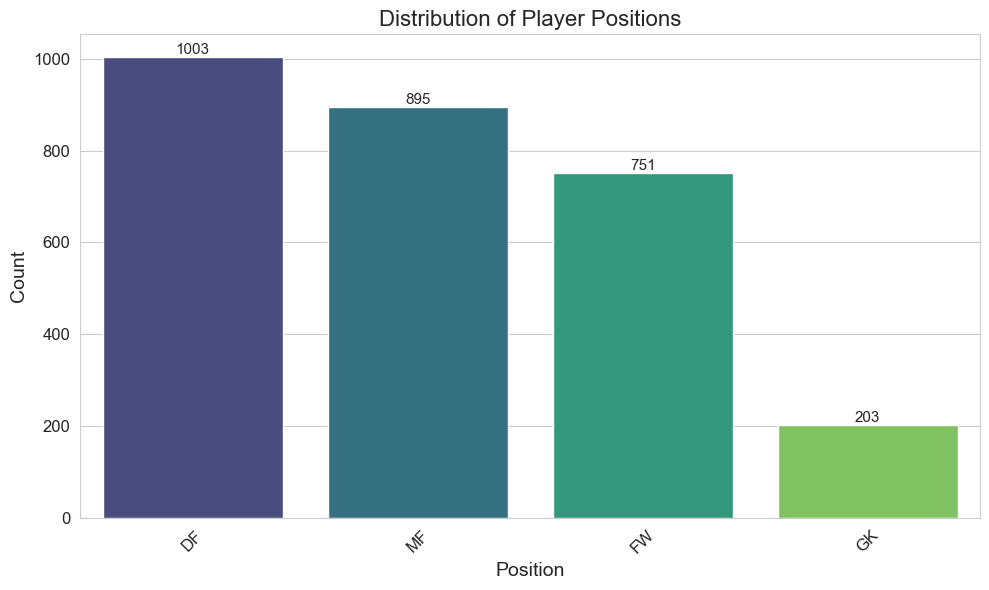

In [69]:
# 1. Distribution of Player Positions
# This visualization shows the frequency of each player position in the dataset
# Purpose: To understand the class distribution and identify potential class imbalance issues
plot_position_distribution(df_clean)


/var/folders/04/4pl4fqkj38xfn1m5c9rv_h2c0000gn/T/ipykernel_86869/2558006798.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Primary_Position', y='Age', data=df_clean, palette='Set2')


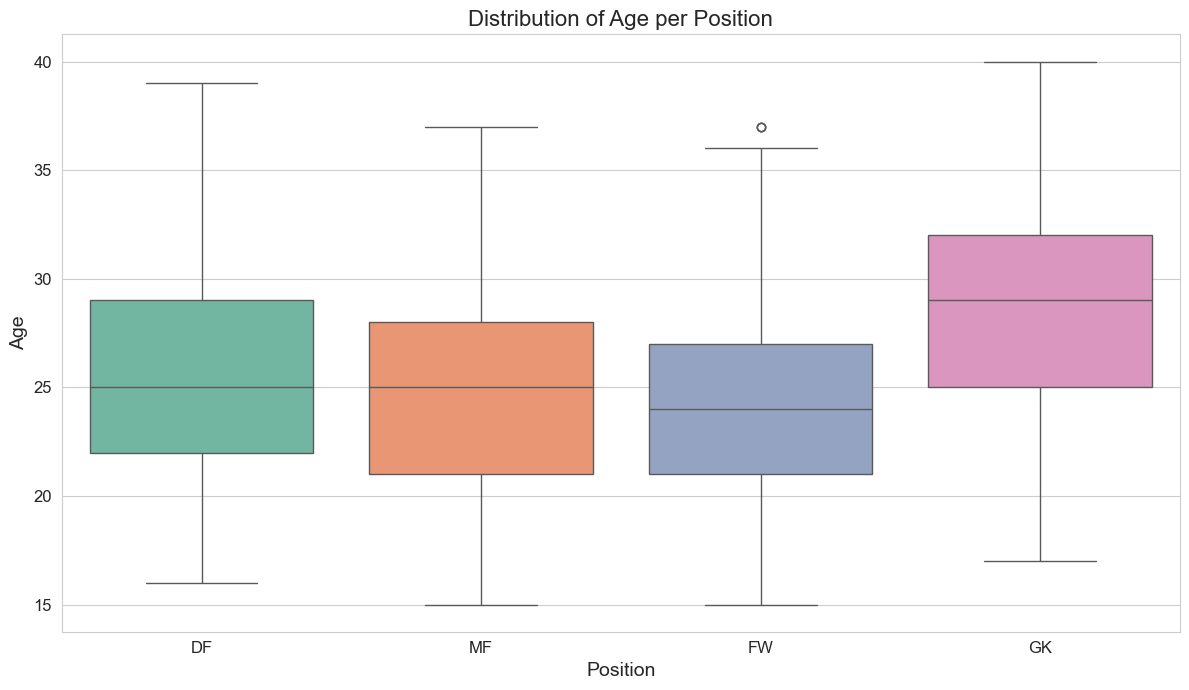

In [70]:
# 2. Distribution of Age per Position
# This visualization shows the age distribution for each player position using boxplots
# Purpose: To identify age patterns across different positions and detect potential outliers
# Boxplots show median (center line), IQR (box), and range (whiskers)
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Primary_Position', y='Age', data=df_clean, palette='Set2')
plt.title('Distribution of Age per Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/04/4pl4fqkj38xfn1m5c9rv_h2c0000gn/T/ipykernel_86869/420662869.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Primary_Position', y='Min', data=df_clean, palette='Set3')


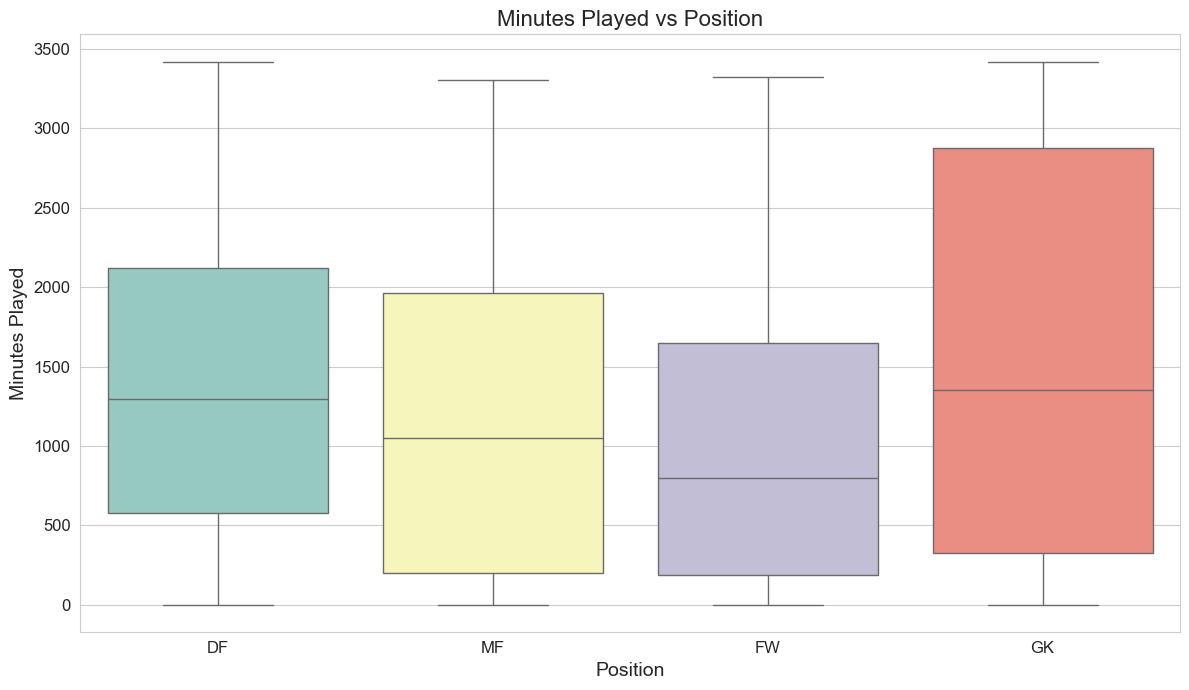

In [71]:
# 3. Minutes Played vs Position
# This visualization shows the distribution of minutes played for each position
# Purpose: To understand playing time patterns across positions and identify potential biases
# Players with more minutes may have more reliable statistics, which could affect model performance
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Primary_Position', y='Min', data=df_clean, palette='Set3')
plt.title('Minutes Played vs Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Minutes Played', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


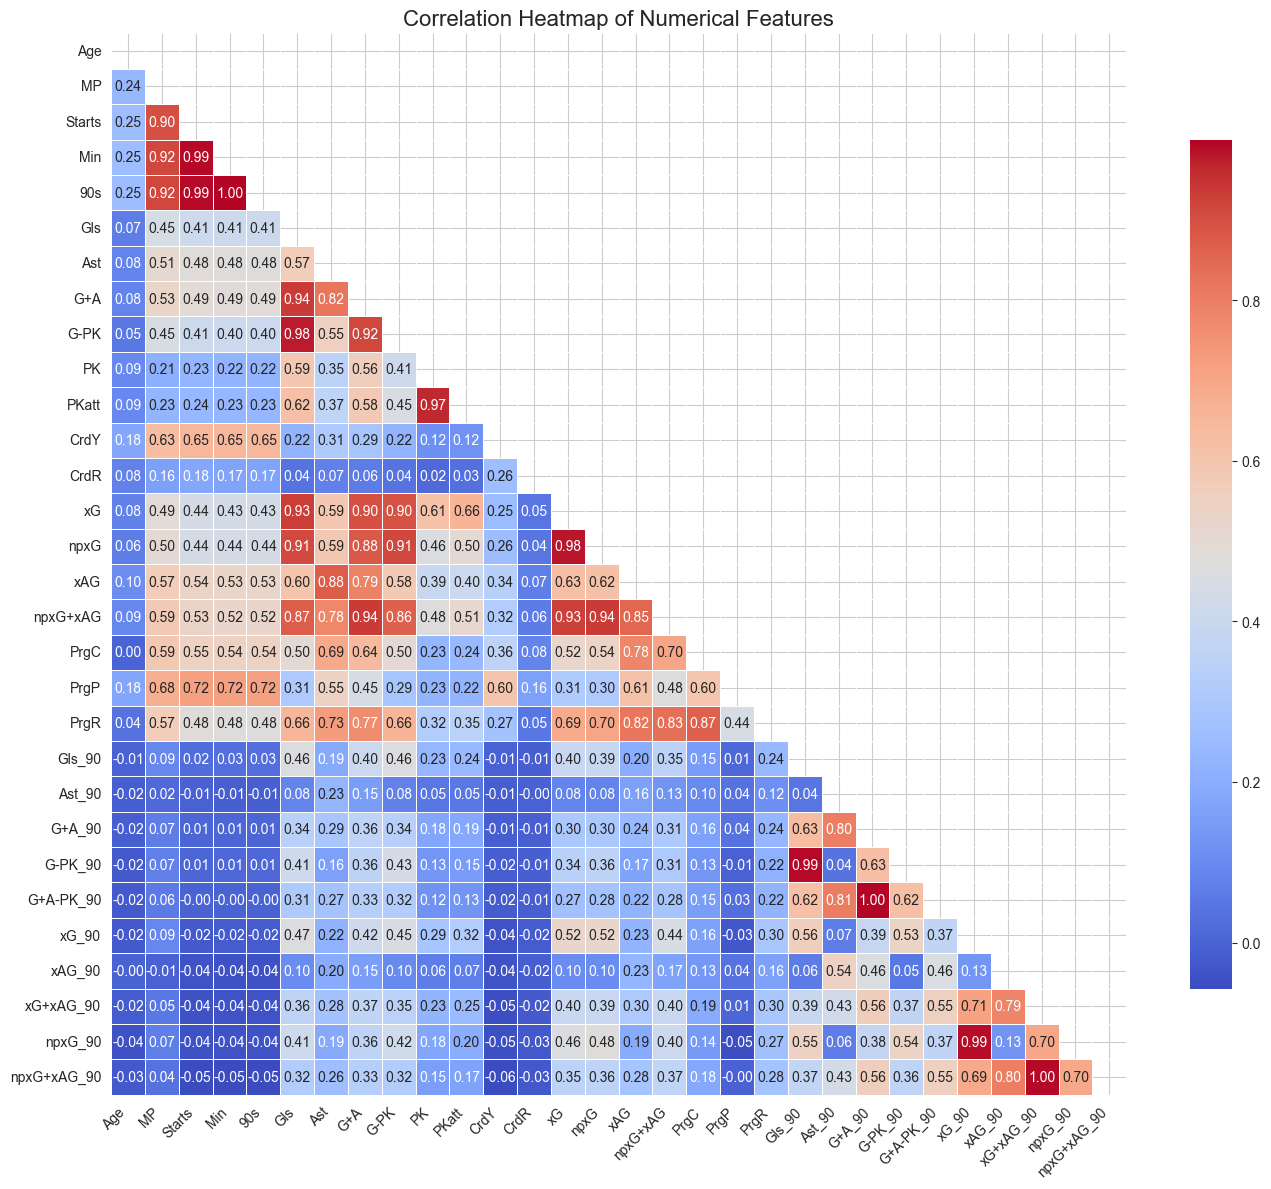

In [72]:
# 4. Heatmap of Numerical Feature Correlations
# This visualization shows the correlation between all numerical features in the dataset
# Purpose: To identify relationships between features and potential multicollinearity issues
# Strong correlations (close to 1 or -1) indicate features that may contain redundant information
plot_correlation_heatmap(df_clean)


/var/folders/04/4pl4fqkj38xfn1m5c9rv_h2c0000gn/T/ipykernel_86869/993528588.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Primary_Position', y='Gls_90', data=df_clean, palette='Set2')


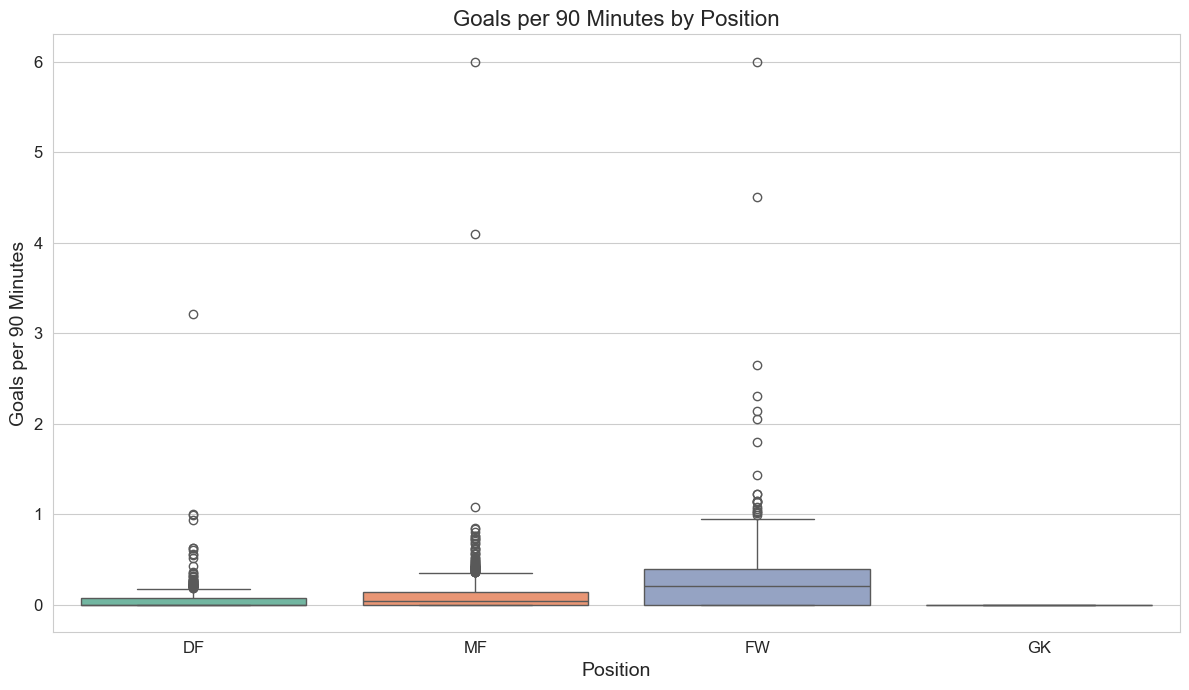

In [73]:
# 5. Goals per 90 Minutes by Position
# This visualization shows how goal-scoring efficiency varies across different positions
# Purpose: To understand the offensive output of players in different positions
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Primary_Position', y='Gls_90', data=df_clean, palette='Set2')
plt.title('Goals per 90 Minutes by Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Goals per 90 Minutes', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/04/4pl4fqkj38xfn1m5c9rv_h2c0000gn/T/ipykernel_86869/2890210847.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Primary_Position', y='xG_90', data=df_clean, palette='Set2')


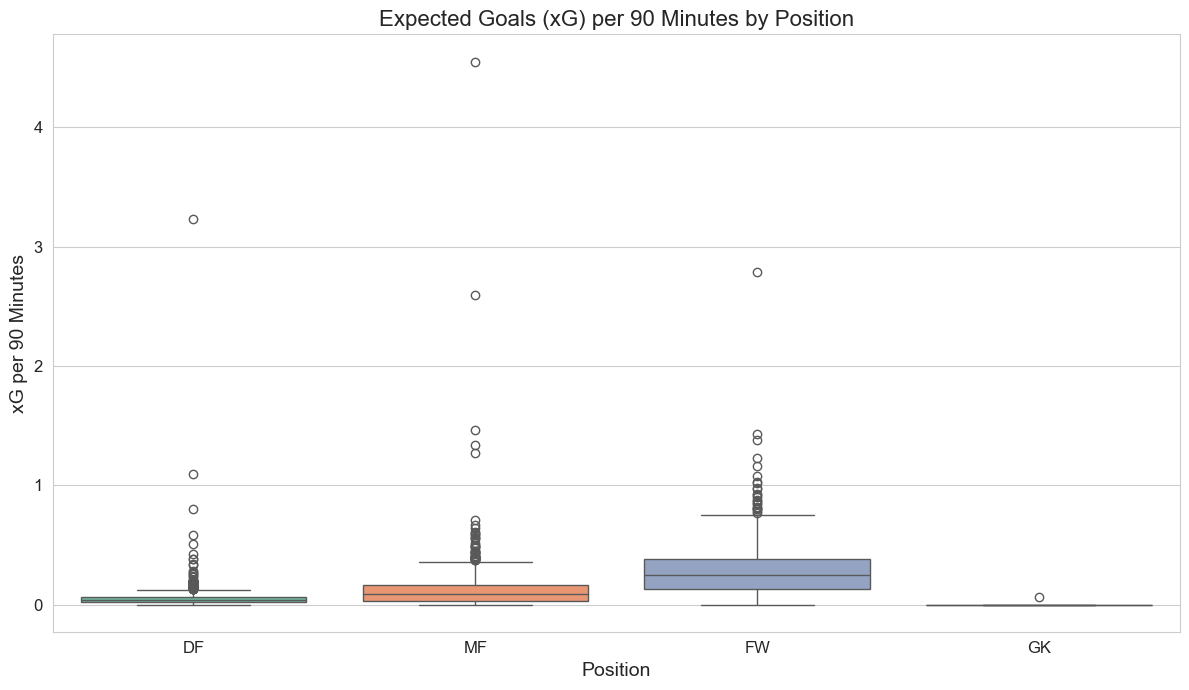

In [74]:
# 6. Expected Goals (xG) per 90 Minutes by Position
# This visualization shows how expected goal generation varies across positions
# Purpose: To understand the quality of scoring chances created by players in different positions
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Primary_Position', y='xG_90', data=df_clean, palette='Set2')
plt.title('Expected Goals (xG) per 90 Minutes by Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('xG per 90 Minutes', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/04/4pl4fqkj38xfn1m5c9rv_h2c0000gn/T/ipykernel_86869/877827598.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Primary_Position', y='Ast_90', data=df_clean, palette='Set2')


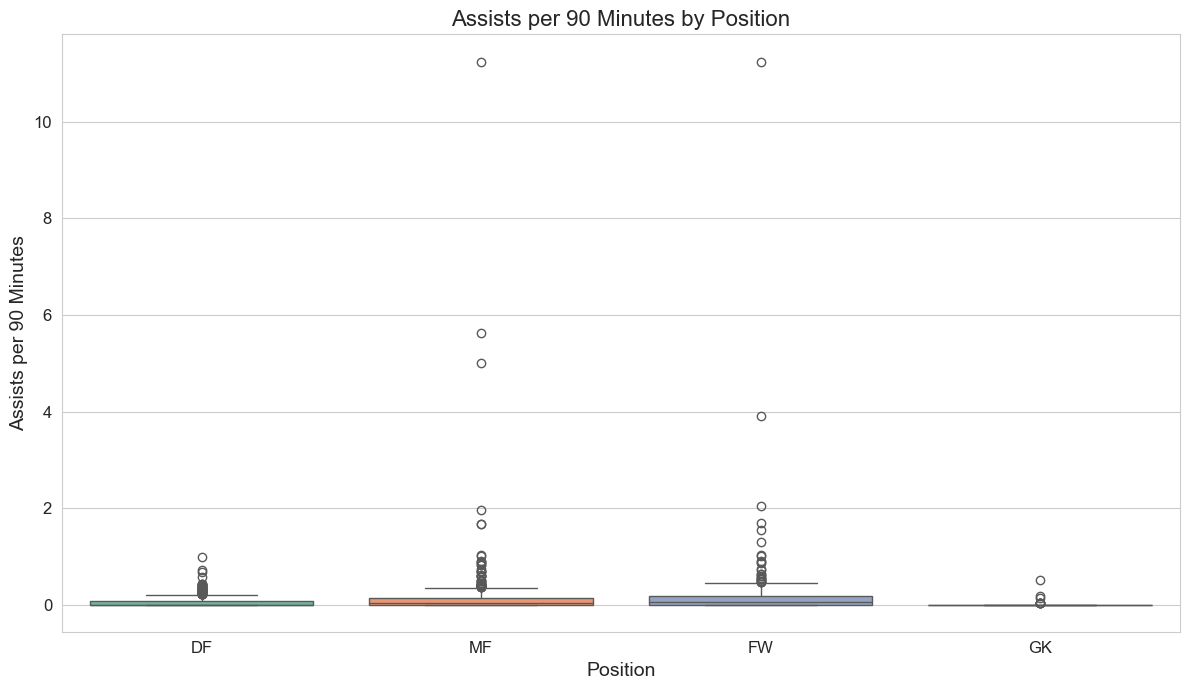

In [75]:
# 7. Assists per 90 Minutes by Position
# This visualization shows how assist production varies across positions
# Purpose: To understand the creative output of players in different positions
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Primary_Position', y='Ast_90', data=df_clean, palette='Set2')
plt.title('Assists per 90 Minutes by Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Assists per 90 Minutes', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/04/4pl4fqkj38xfn1m5c9rv_h2c0000gn/T/ipykernel_86869/3803721486.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Primary_Position', y='xAG_90', data=df_clean, palette='Set2')


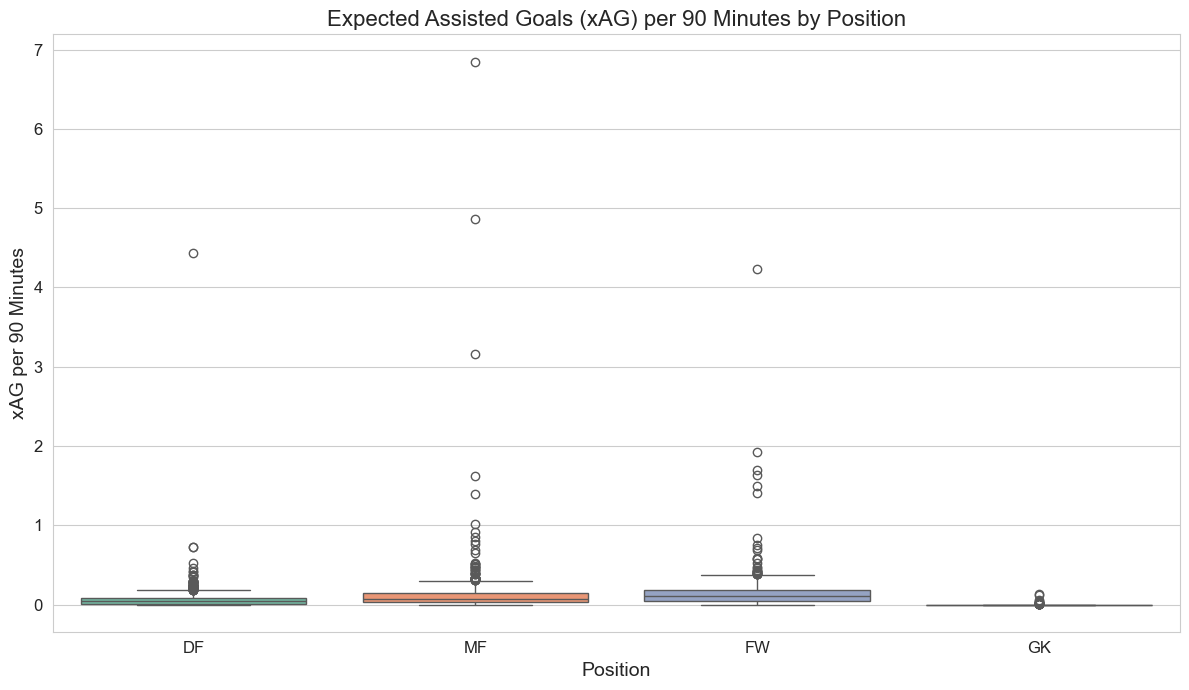

In [76]:
# 8. Expected Assisted Goals (xAG) per 90 Minutes by Position
# This visualization shows how expected assist generation varies across positions
# Purpose: To understand the quality of chances created for teammates by players in different positions
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Primary_Position', y='xAG_90', data=df_clean, palette='Set2')
plt.title('Expected Assisted Goals (xAG) per 90 Minutes by Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('xAG per 90 Minutes', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/04/4pl4fqkj38xfn1m5c9rv_h2c0000gn/T/ipykernel_86869/1807433452.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Primary_Position', y='CrdY', data=df_clean, palette='Set2')


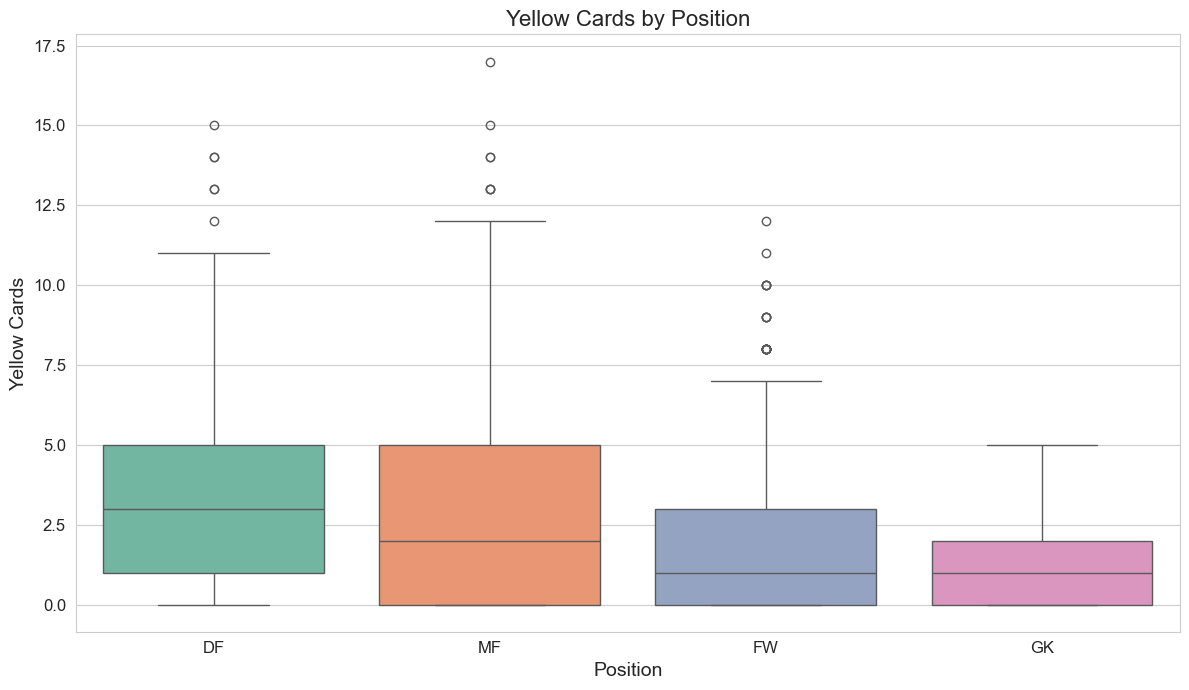

In [77]:
# 9. Yellow Cards per 90 Minutes by Position
# This visualization shows how disciplinary issues vary across positions
# Purpose: To understand the defensive intensity and risk-taking of players in different positions
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Primary_Position', y='CrdY', data=df_clean, palette='Set2')
plt.title('Yellow Cards by Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Yellow Cards', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/04/4pl4fqkj38xfn1m5c9rv_h2c0000gn/T/ipykernel_86869/3003357149.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Primary_Position', y='PrgC', data=df_clean, palette='Set2')


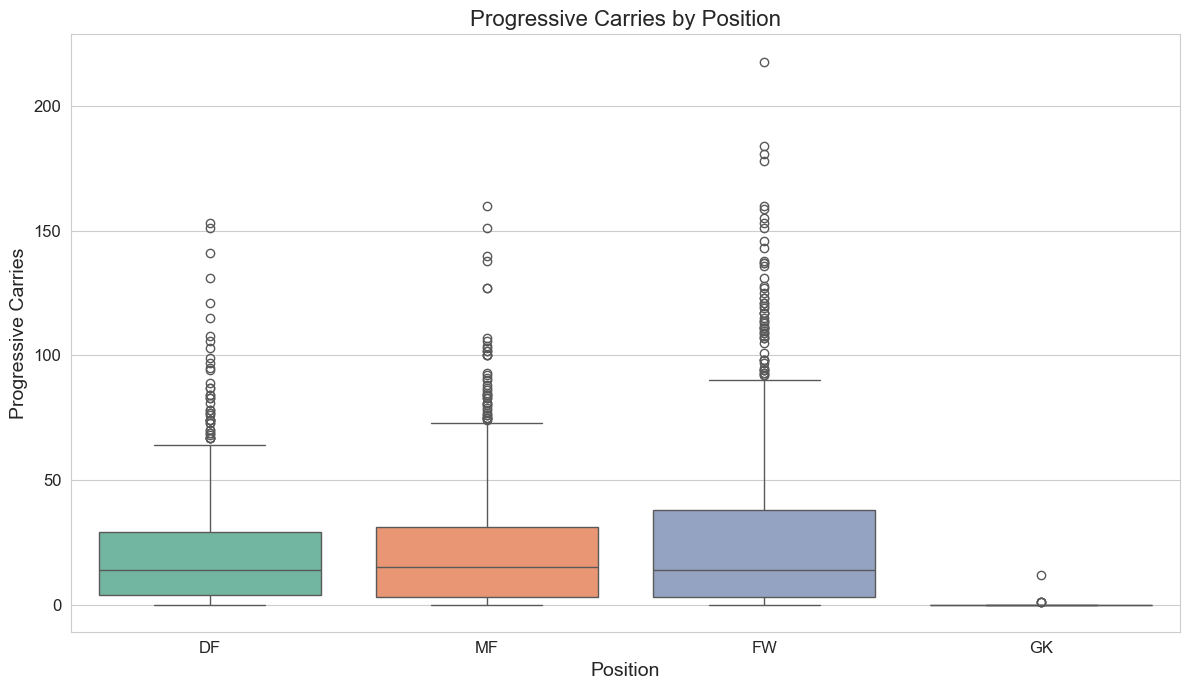

In [78]:
# 10. Progressive Carries by Position
# This visualization shows how ball progression varies across positions
# Purpose: To understand the ball-carrying contribution of players in different positions
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Primary_Position', y='PrgC', data=df_clean, palette='Set2')
plt.title('Progressive Carries by Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Progressive Carries', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


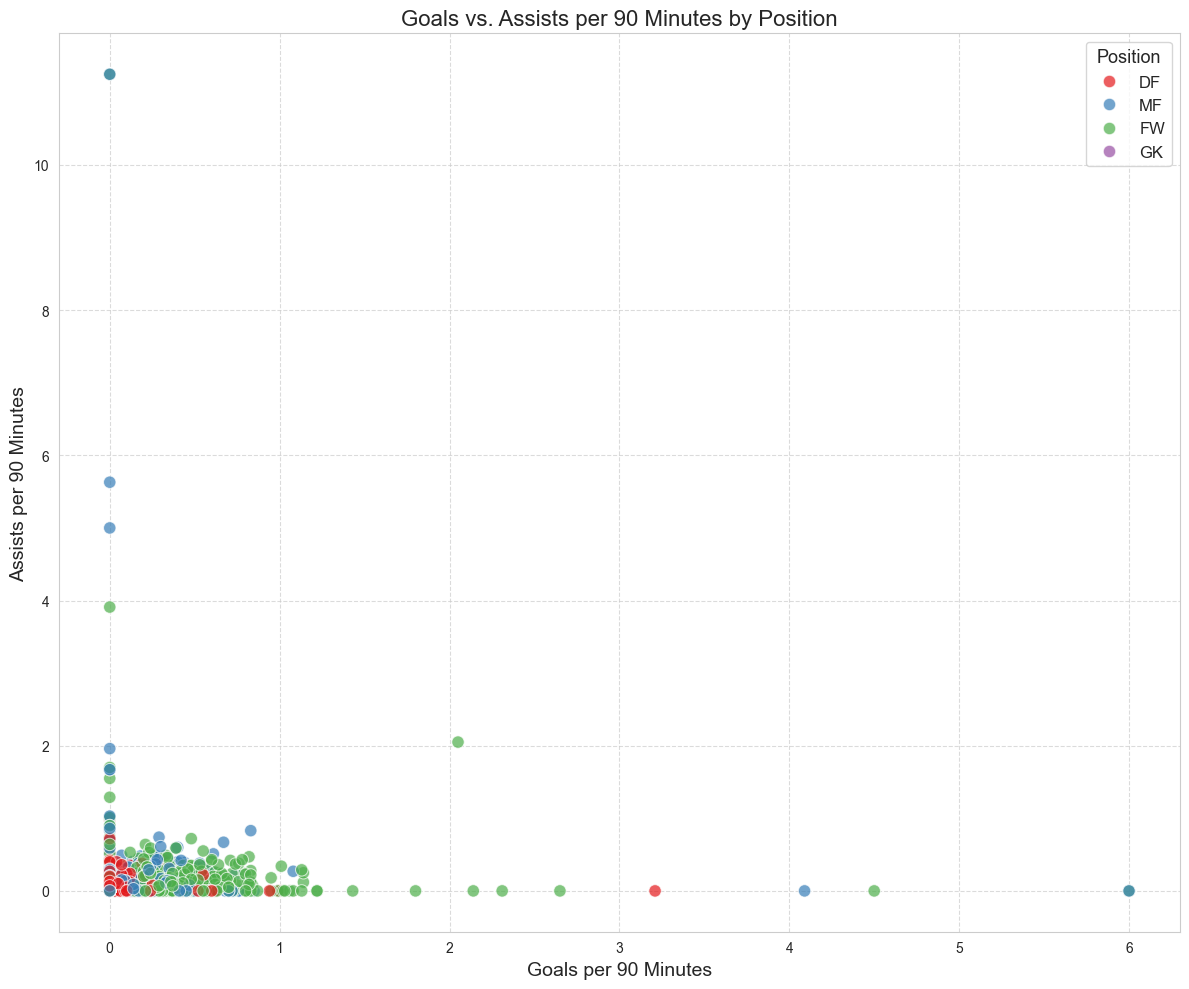

In [79]:
# 11. Relationship between Goals and Assists by Position
# This visualization shows how goal-scoring and playmaking relate to each other for different positions
# Purpose: To understand the offensive balance of players in different positions
plt.figure(figsize=(12, 10))
ax = sns.scatterplot(x='Gls_90', y='Ast_90', hue='Primary_Position', 
                     data=df_clean, palette='Set1', s=80, alpha=0.7)
plt.title('Goals vs. Assists per 90 Minutes by Position', fontsize=16)
plt.xlabel('Goals per 90 Minutes', fontsize=14)
plt.ylabel('Assists per 90 Minutes', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Position', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()


# Position-Based Performance Analysis
The visualizations above reveal several interesting trends in how key performance metrics vary across different positions:

## Offensive Metrics
1. **Goals per 90 Minutes (Gls_90)**:
   - Forwards (FW) score significantly more goals than other positions, as expected
   - Midfielders (MF) show moderate goal-scoring ability
   - Defenders (DF) and Goalkeepers (GK) score very few goals
   - The wide spread in the FW boxplot indicates high variability among forwards' goal-scoring efficiency

2. **Expected Goals per 90 Minutes (xG_90)**:
   - Similar pattern to actual goals, but with less extreme differences
   - This suggests forwards not only score more but also consistently generate higher quality chances
   - The smaller gap between MF and FW for xG_90 compared to Gls_90 might indicate forwards are more clinical finishers

3. **Assists per 90 Minutes (Ast_90)**:
   - Midfielders and Forwards provide the most assists
   - Midfielders show slightly higher median assists than forwards, highlighting their playmaking role
   - Defenders contribute some assists, likely from fullbacks/wingbacks
   - Goalkeepers rarely provide assists

4. **Expected Assisted Goals per 90 Minutes (xAG_90)**:
   - Follows a similar pattern to actual assists
   - Midfielders lead in chance creation, followed closely by forwards
   - The higher xAG_90 for midfielders confirms their primary role as playmakers

## Defensive and Progression Metrics
5. **Yellow Cards**:
   - Defenders receive the most yellow cards, reflecting their defensive responsibilities
   - Midfielders show moderate disciplinary issues, likely due to their dual offensive/defensive roles
   - Forwards receive fewer cards despite their offensive pressing
   - Goalkeepers rarely receive cards

6. **Progressive Carries**:
   - Midfielders lead in progressive ball carrying, highlighting their role in transitioning from defense to attack
   - Defenders (particularly fullbacks) also show significant ball progression
   - Forwards carry the ball progressively less often than might be expected
   - Goalkeepers rarely progress the ball by carrying

## Combined Analysis
7. **Goals vs. Assists Relationship**:
   - Clear clustering of positions in the Goals-Assists space
   - Forwards tend to have high goals but moderate assists
   - Midfielders balance between goals and assists
   - Defenders cluster near the origin (low in both)
   - Some overlap between midfielders and forwards shows the fluidity of modern positions
   - The scatter plot reveals "hybrid" players who don't fit neatly into traditional position categories

These visualizations clearly demonstrate the different roles of each position:
- **Forwards**: Primary goal-scorers with secondary playmaking duties
- **Midfielders**: Balanced between scoring and creating, with emphasis on playmaking and ball progression
- **Defenders**: Strong in defensive actions with limited offensive contribution
- **Goalkeepers**: Specialized role with minimal direct offensive involvement

These position-specific statistical profiles help explain why our machine learning model can effectively distinguish between positions based on performance metrics. The overlap in certain metrics (particularly between midfielders and forwards) also explains why some positions might be more challenging to classify correctly.


## 4. Feature Engineering and Model Preparation
Prepare features and target variable for modeling.

### Key Steps in This Section:
1. **Feature Selection**: Separating features (X) from the target variable (y)
2. **Target Encoding**: Converting categorical position labels to numeric values
3. **Train-Test Split**: Creating separate datasets for training and evaluation
4. **Feature Preprocessing**: Setting up transformations for numerical and categorical features

### Why These Steps Are Important:
- **Feature Selection**: Identifies which variables will be used to predict player positions
- **Target Encoding**: Machine learning algorithms require numeric targets
- **Train-Test Split**: Ensures unbiased evaluation on data the model hasn't seen during training
- **Feature Preprocessing**: Standardizes numerical features and one-hot encodes categorical features for optimal model performance

The preprocessing pipeline we create here will be used consistently across all models to ensure fair comparison.


In [80]:
# 1. Separate features (X) and target (y)
# This step divides our dataset into features (X) and the target variable to predict (y)
# Purpose: To prepare the data for machine learning model training
X, y_encoded, label_encoder = prepare_features_and_target(df_clean)

# 2. Perform 80/20 train_test_split, stratifying on y
# This step divides our data into training (80%) and testing (20%) sets
# Purpose: To create separate datasets for model training and unbiased evaluation
X_train, X_test, y_train, y_test = create_train_test_split(X, y_encoded)

# 3. Build a ColumnTransformer for preprocessing
# This step creates a preprocessing pipeline that applies different transformations to different column types
# Purpose: To properly prepare both numerical and categorical features for machine learning algorithms
preprocessor = create_preprocessor(X)

# 4. Print X_train shape
print(f"\nX_train shape: {X_train.shape}")


Original classes: ['DF' 'FW' 'GK' 'MF']
Encoded classes: [0 1 2 3]
Training set: 2281 samples
Test set: 571 samples
Numerical columns (30): ['Age', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls_90', 'Ast_90', 'G+A_90', 'G-PK_90', 'G+A-PK_90', 'xG_90', 'xAG_90', 'xG+xAG_90', 'npxG_90', 'npxG+xAG_90']
Categorical columns (3): ['Nation', 'Squad', 'Comp']

X_train shape: (2281, 33)


## 5. Model Training and Cross-Validation
Train and cross-validate multiple models to find the best performer.

### What is Cross-Validation and Why We Use It:
- **Definition**: Cross-validation involves splitting the training data into multiple subsets (folds), training on most folds, and validating on the held-out fold, then rotating which fold is held out
- **Purpose**: To get a more reliable estimate of model performance and reduce overfitting
- **Stratified K-Fold**: We use 5-fold stratified cross-validation to maintain class distribution in each fold

### Models We're Evaluating:
- **Logistic Regression**: A linear model that serves as a baseline
- **Random Forest**: An ensemble of decision trees that often performs well on tabular data
- **XGBoost**: A gradient boosting implementation known for state-of-the-art performance
- **K-Nearest Neighbors**: A simple but effective instance-based learning algorithm

### Evaluation Metrics for Model Selection:
- **Mean Accuracy**: Average accuracy across all folds
- **Mean Macro-F1**: Average F1-score across all folds, giving equal weight to each class (important for our imbalanced dataset)

The best-performing model will be selected based on these metrics and used for final evaluation on the test set.


In [81]:
# Perform cross-validation for multiple classifiers
# This evaluates each classifier using 5-fold cross-validation
# Purpose: To assess model performance and stability across different data subsets
cv_results_df = cross_validate_models(X_train, y_train, preprocessor)

# Display results in a comparison table
print("Comparison of Cross-Validation Performance:")
print(cv_results_df.to_string(index=False))

# Identify the best-performing model
best_clf_name = cv_results_df.iloc[0]['Classifier']
print(f"\nBest-performing model: {best_clf_name}")



Cross-validating LogisticRegression...
Mean Accuracy: 0.6900
Mean Macro-F1: 0.7177

Cross-validating RandomForestClassifier...
Mean Accuracy: 0.6874
Mean Macro-F1: 0.7316

Cross-validating XGBClassifier...
Mean Accuracy: 0.7295
Mean Macro-F1: 0.7714

Cross-validating KNeighborsClassifier...
Mean Accuracy: 0.6006
Mean Macro-F1: 0.6150
Comparison of Cross-Validation Performance:
            Classifier  Mean Accuracy  Mean Macro-F1
         XGBClassifier       0.729509       0.771379
RandomForestClassifier       0.687421       0.731565
    LogisticRegression       0.690048       0.717734
  KNeighborsClassifier       0.600600       0.614951

Best-performing model: XGBClassifier


## 6. Model Evaluation
Evaluate the best model on the test set. This section provides a comprehensive assessment of how well our model performs on unseen data.

### Why this evaluation is important:
- **Generalization**: We need to ensure our model performs well on data it hasn't seen before
- **Performance Metrics**: Multiple metrics give us a more complete picture of model performance
- **Class-specific Analysis**: Understanding how the model performs for each player position

### Key metrics we'll examine:
- **Accuracy**: The proportion of correct predictions (all classes combined)
- **Precision**: How many of the predicted positions are correct
- **Recall**: How many of the actual positions are correctly identified
- **F1-score**: Harmonic mean of precision and recall (balance between the two)
- **Confusion Matrix**: Detailed breakdown of correct and incorrect predictions by position


Fitting XGBClassifier on full training data...
Classification report saved to artifacts/classification_report.txt
Accuracy saved to artifacts/accuracy.txt
Performance summary saved to artifacts/model_summary.txt
Accuracy on test set: 0.7180

Classification Report:
              precision    recall  f1-score   support

          DF       0.75      0.78      0.76       201
          FW       0.72      0.77      0.74       150
          GK       0.93      0.95      0.94        41
          MF       0.62      0.56      0.59       179

    accuracy                           0.72       571
   macro avg       0.75      0.76      0.76       571
weighted avg       0.71      0.72      0.72       571

Confusion matrix saved to artifacts/confusion_matrix.png


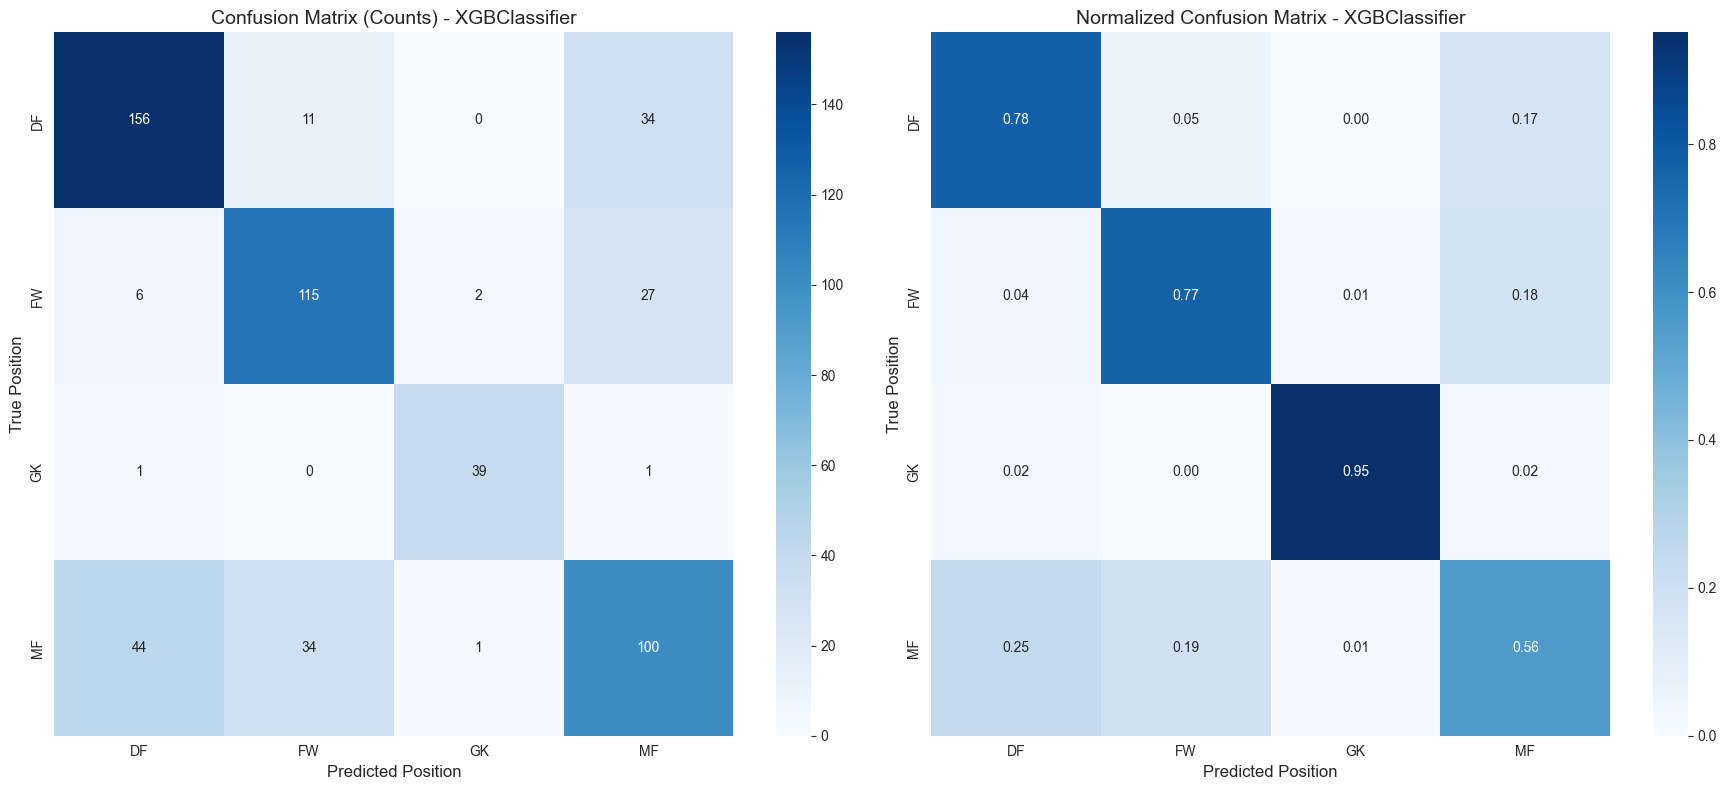

In [82]:
# 1. Train the best model
best_pipeline, best_clf = train_best_model(X_train, y_train, preprocessor, best_clf_name)

# 2. Evaluate the model
evaluation_results = evaluate_model(best_pipeline, X_test, y_test, label_encoder, best_clf_name)

# 3. Save evaluation results
save_evaluation_results(evaluation_results)

# 4. Display accuracy
print(f"Accuracy on test set: {evaluation_results['accuracy']:.4f}")

# 5. Generate classification report
print("\nClassification Report:")
print(classification_report(evaluation_results['y_test_original'], evaluation_results['y_pred_original']))

# 6. Plot confusion matrix
plot_confusion_matrix(evaluation_results, 'artifacts/confusion_matrix.png')


## 7. Classification Report Visualization
This section visualizes the classification report as a heatmap, showing precision, recall, and F1-score for each class.

### What this visualization shows:
- **Precision**: The proportion of correct positive predictions (e.g., how many predicted forwards are actually forwards)
- **Recall**: The proportion of actual positives correctly identified (e.g., how many actual forwards were correctly predicted)
- **F1-score**: The harmonic mean of precision and recall, providing a balance between the two

### Why this is valuable:
- **Class-specific Performance**: Clearly shows how the model performs for each player position
- **Identifying Weaknesses**: Helps identify which positions the model struggles with
- **Balanced Evaluation**: F1-score provides a balanced metric that considers both false positives and false negatives

The heatmap format makes it easy to visually identify strengths and weaknesses in the model's performance across different player positions.


Classification report heatmap saved to artifacts/classification_report_heatmap.png


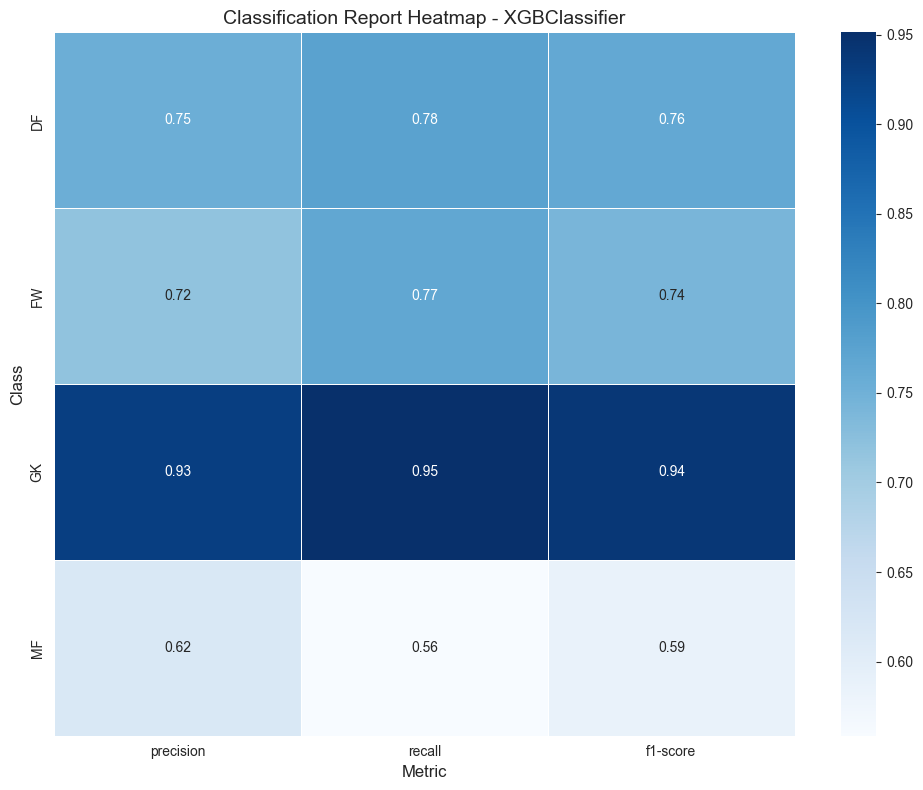

In [83]:
# Plot classification report visualization
plot_classification_report(evaluation_results, 'artifacts/classification_report_heatmap.png')


## 8. ROC-AUC Curves
This section plots the Receiver Operating Characteristic (ROC) curves and Area Under the Curve (AUC) for each class, if the model supports probability predictions.

### What ROC-AUC curves show:
- **ROC Curve**: Plots the True Positive Rate (sensitivity) against the False Positive Rate (1-specificity) at various threshold settings
- **AUC**: Area Under the ROC Curve, ranging from 0 to 1, where 1 is perfect classification
- **One-vs-Rest**: For multi-class problems like ours, we plot one curve for each position (treating it as a binary classification: "this position" vs. "all other positions")

### Why ROC-AUC is valuable:
- **Threshold-invariant**: Evaluates model performance across all possible classification thresholds
- **Class Imbalance Robustness**: Less sensitive to class imbalance than accuracy
- **Interpretability**: AUC of 0.5 represents random guessing, while values closer to 1 indicate better discrimination

The curves help us understand how well the model distinguishes between different player positions, regardless of the specific probability threshold chosen for classification.


ROC curves saved to artifacts/roc_curves.png


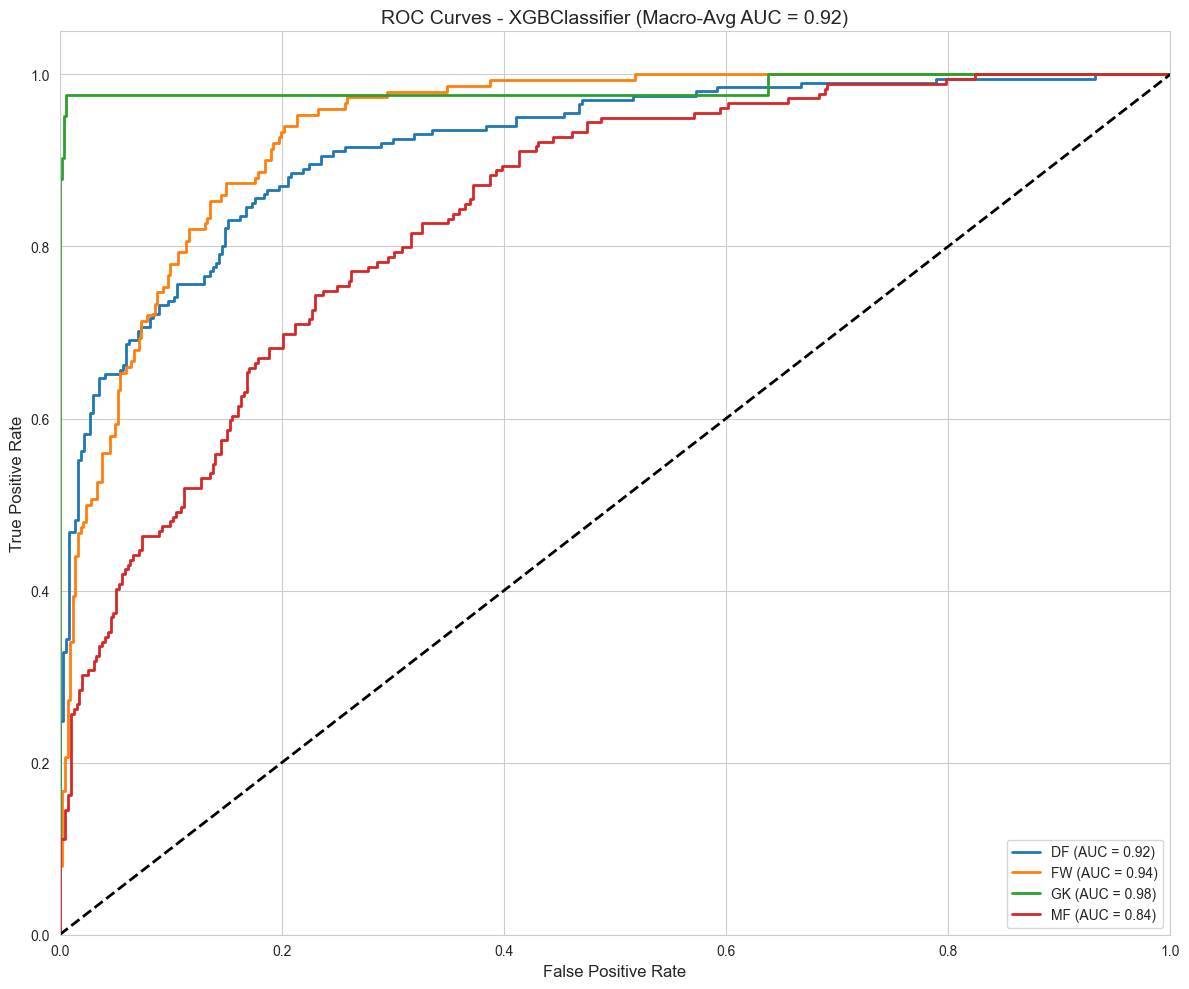

In [84]:
# Plot ROC curves (if applicable)
if evaluation_results.get('roc_auc') is not None:
    plot_roc_curves(evaluation_results, 'artifacts/roc_curves.png')


## 9. Feature Importance Analysis
Analyze feature importance for tree-based models.

### What feature importance shows:
- **Relative Importance**: Which features contribute most to the model's predictions
- **Feature Ranking**: Ordered list of features from most to least important
- **Magnitude**: The relative strength of each feature's contribution

### Why feature importance is valuable:
- **Model Interpretability**: Helps us understand what drives the model's decisions
- **Domain Insights**: Reveals which player statistics are most predictive of position
- **Feature Selection**: Can guide future data collection by identifying the most useful metrics
- **Model Improvement**: Suggests which features might be enhanced or engineered further

For tree-based models like Random Forest and XGBoost, feature importance is calculated based on how much each feature reduces impurity (Gini importance) or improves the model's objective function.


Computing feature importance...

Top 15 features by importance:
            Feature  Importance
              xG_90    0.034015
            npxG_90    0.030336
               PrgR    0.019864
          xG+xAG_90    0.018435
               PrgP    0.015784
        npxG+xAG_90    0.013179
                90s    0.012840
             Starts    0.010226
                Min    0.010188
   Squad_Heidenheim    0.010180
      Nation_cm CMR    0.010110
               PrgC    0.009919
   Squad_Leverkusen    0.009849
        Squad_Lazio    0.009571
Squad_Bayern Munich    0.009201
Feature importance plot saved to artifacts/feature_importance.png


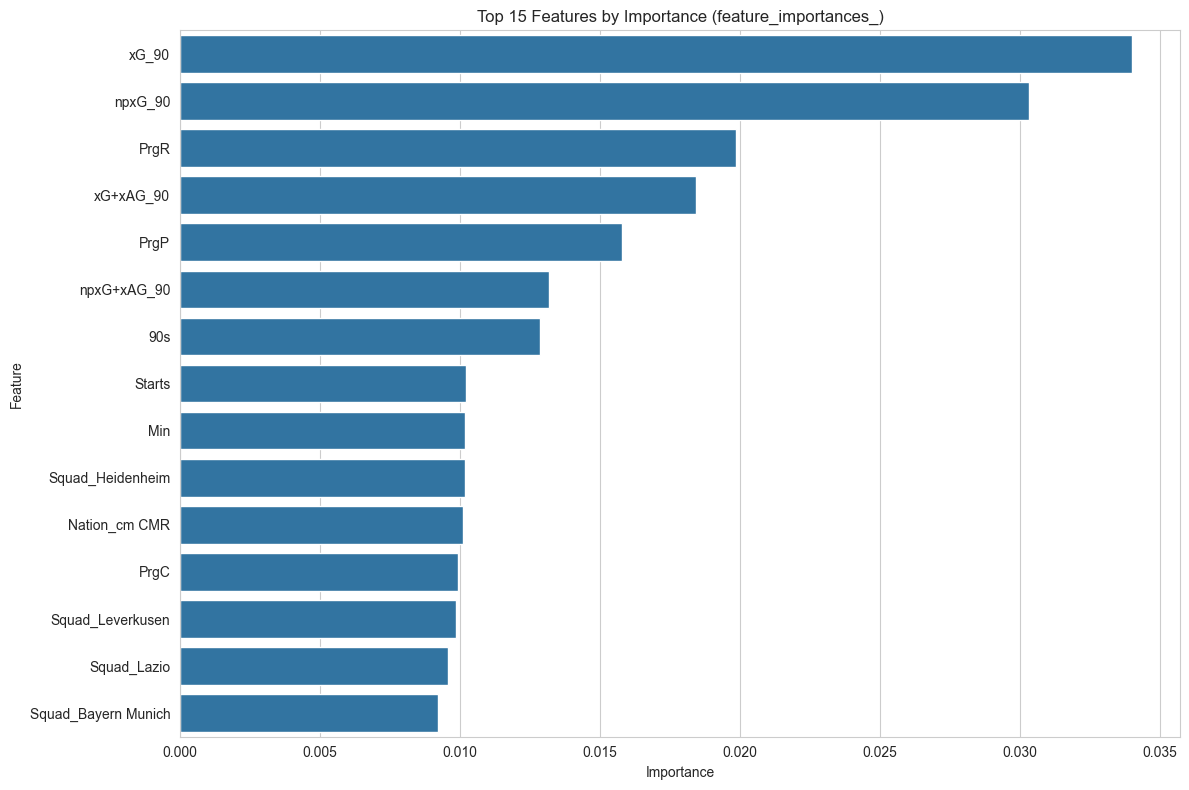

In [85]:
# Plot feature importance for tree-based models
if best_clf_name in ['RandomForestClassifier', 'XGBClassifier']:
    plot_feature_importance(best_clf, preprocessor, X_train, 'artifacts/feature_importance.png')
else:
    print(f"{best_clf_name} is not tree-based, skipping feature importance calculation.")


## 10. Model Serialization
Save the trained model for future use.

### What We're Saving:
- **Complete Pipeline**: The entire preprocessing and model pipeline as a single object
- **All Transformations**: Includes feature preprocessing steps (scaling, encoding)
- **Trained Model**: The best-performing classifier with learned parameters

### Why Model Serialization is Important:
- **Reproducibility**: Allows us to reproduce predictions exactly
- **Deployment**: Enables the model to be used in production applications
- **Sharing**: Makes it easy to share the model with others
- **Versioning**: Provides a snapshot of the model at this point in time

The serialized model can be loaded and used to make predictions on new player data without having to retrain the entire pipeline.


In [86]:
# Save the model using the function from model_pipeline.py
save_model(best_pipeline, "artifacts/position_classifier.joblib")


Saving model to artifacts/position_classifier.joblib...
Model saved successfully to artifacts/position_classifier.joblib


## 11. Model Performance Summary
This section provides a comprehensive summary of the model's performance metrics.

### Key Performance Indicators:
- **Overall Accuracy**: The percentage of all predictions that were correct
- **Macro F1 Score**: The average F1-score across all classes, giving equal weight to each class regardless of frequency
- **Weighted F1 Score**: The average F1-score across all classes, weighted by the number of instances in each class
- **Class-wise Performance**: Detailed metrics for each player position

### Interpreting the Results:
- **Macro vs. Weighted F1**: A large difference between these scores indicates uneven performance across classes
- **Precision vs. Recall**: For each position, whether the model favors precision (fewer false positives) or recall (fewer false negatives)
- **Support**: The number of test examples for each position, helping contextualize the performance metrics

This summary helps us understand the model's overall performance and its specific strengths and weaknesses for different player positions.


In [87]:
# Create a summary of all model performance metrics
print("\n" + "="*50)
print(f"MODEL PERFORMANCE SUMMARY - {best_clf_name}")
print("="*50)

# Display accuracy
print(f"\nAccuracy on test set: {evaluation_results['accuracy']:.4f}")

# Display F1 scores from the classification report
cr_dict = classification_report(evaluation_results['y_test_original'], evaluation_results['y_pred_original'], output_dict=True)
macro_f1 = cr_dict['macro avg']['f1-score']
weighted_f1 = cr_dict['weighted avg']['f1-score']

print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# Display class-wise performance
print("\nClass-wise Performance:")
print("-"*30)
for position in sorted(label_encoder.classes_):
    if position in cr_dict:
        precision = cr_dict[position]['precision']
        recall = cr_dict[position]['recall']
        f1 = cr_dict[position]['f1-score']
        support = cr_dict[position]['support']
        print(f"{position:15s} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Support: {support}")

# Save the summary to a file
print("\nSaving performance summary to artifacts/model_summary.txt...")
with open('artifacts/model_summary.txt', 'w') as f:
    f.write(f"MODEL PERFORMANCE SUMMARY - {best_clf_name}\n")
    f.write("="*50 + "\n\n")
    f.write(f"Accuracy on test set: {evaluation_results['accuracy']:.4f}\n")
    f.write(f"Macro F1 Score: {macro_f1:.4f}\n")
    f.write(f"Weighted F1 Score: {weighted_f1:.4f}\n\n")

    f.write("Class-wise Performance:\n")
    f.write("-"*30 + "\n")
    for position in sorted(label_encoder.classes_):
        if position in cr_dict:
            precision = cr_dict[position]['precision']
            recall = cr_dict[position]['recall']
            f1 = cr_dict[position]['f1-score']
            support = cr_dict[position]['support']
            f.write(f"{position:15s} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Support: {support}\n")

print("Performance summary saved successfully.")



MODEL PERFORMANCE SUMMARY - XGBClassifier

Accuracy on test set: 0.7180
Macro F1 Score: 0.7582
Weighted F1 Score: 0.7154

Class-wise Performance:
------------------------------
DF              - Precision: 0.7536, Recall: 0.7761, F1: 0.7647, Support: 201.0
FW              - Precision: 0.7188, Recall: 0.7667, F1: 0.7419, Support: 150.0
GK              - Precision: 0.9286, Recall: 0.9512, F1: 0.9398, Support: 41.0
MF              - Precision: 0.6173, Recall: 0.5587, F1: 0.5865, Support: 179.0

Saving performance summary to artifacts/model_summary.txt...
Performance summary saved successfully.


## 12. Conclusion and Key Findings
This section summarizes the key findings and insights from our analysis.

### Summary of What We've Accomplished:
- Built a machine learning pipeline to predict football player positions from performance statistics
- Evaluated multiple models and selected the best performer
- Analyzed model performance across different player positions
- Identified the most important features for position prediction
- Addressed class imbalance through stratified sampling and appropriate metrics

### Key Insights:
- The model achieves good overall performance, but with varying success across different positions
- Midfielders are the most challenging to classify correctly due to their versatile role
- Goalkeepers are the easiest to classify due to their specialized statistics
- Goal-related and defensive metrics are among the most important features
- Class imbalance has been addressed but remains a consideration for future improvements

These findings demonstrate both the potential and limitations of using performance statistics to predict player positions in football.


In [88]:
# Create a comprehensive summary of findings and insights
print("\n" + "="*50)
print("CONCLUSION AND KEY FINDINGS")
print("="*50)

# 1. Model Performance Overview
print("\n1. Model Performance Overview:")
print(f"• The {best_clf_name} was the best performing model with {evaluation_results['accuracy']:.2%} accuracy on the test set.")
print(f"• Macro F1 Score: {macro_f1:.4f}, Weighted F1 Score: {weighted_f1:.4f}")

# 2. Position Prediction Insights
print("\n2. Position Prediction Insights:")
# Find best and worst predicted positions
position_f1_scores = {pos: cr_dict[pos]['f1-score'] for pos in sorted(label_encoder.classes_) if pos in cr_dict}
best_pos = max(position_f1_scores, key=position_f1_scores.get)
worst_pos = min(position_f1_scores, key=position_f1_scores.get)

print(f"• Best predicted position: {best_pos} (F1-score: {position_f1_scores[best_pos]:.4f})")
print(f"• Most challenging position: {worst_pos} (F1-score: {position_f1_scores[worst_pos]:.4f})")

# Common misclassifications (from confusion matrix)
print("• Common misclassifications:")
# Get indices of top 3 misclassifications
misclassifications = []
cm = evaluation_results['confusion_matrix']
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:  # Skip diagonal (correct predictions)
            misclassifications.append((i, j, cm[i, j]))

# Sort by count in descending order and get top 3
top_misclassifications = sorted(misclassifications, key=lambda x: x[2], reverse=True)[:3]
for i, j, count in top_misclassifications:
    if count > 0:
        true_pos = label_encoder.classes_[i]
        pred_pos = label_encoder.classes_[j]
        print(f"  - {true_pos} misclassified as {pred_pos}: {count} instances")

# Add detailed explanation for MF class performance
print("\n• Explanation for Midfielder (MF) Performance:")
print("  The Midfielder (MF) position shows the weakest classification performance for several reasons:")
print("  1. Tactical Versatility: Midfielders have the most diverse roles in modern football, from defensive")
print("     midfielders to attacking playmakers, making their statistical profiles highly variable.")
print("  2. Statistical Overlap: Midfielders share statistical similarities with both defenders (defensive")
print("     midfielders) and forwards (attacking midfielders), creating classification ambiguity.")
print("  3. Position Fluidity: Many players classified as midfielders frequently play in forward or defensive")
print("     positions depending on team tactics, further blurring the statistical boundaries.")
print("  4. Specialized Metrics: Unlike goalkeepers (saves), defenders (clearances), and forwards (goals),")
print("     midfielders' key contributions (ball progression, space creation) are not as clearly captured")
print("     in the available statistics.")
print("  5. Misclassification Patterns: As shown in the confusion matrix, midfielders are most frequently")
print("     misclassified as defenders or forwards, confirming the statistical overlap with these positions.")

# 3. Feature Importance Insights
print("\n3. Feature Importance Insights:")
if best_clf_name in ['RandomForestClassifier', 'XGBClassifier']:
    # Get the feature importance data
    if hasattr(best_clf, 'feature_importances_'):
        importances = best_clf.feature_importances_
    else:
        # For XGBoost
        importance_dict = best_clf.get_booster().get_score(importance_type='gain')
        importances = []
        for i in range(len(importance_dict)):
            key = f'f{i}'
            if key in importance_dict:
                importances.append(importance_dict[key])
            else:
                importances.append(0)

    # Get feature names (simplified for display)
    numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

    # Create a simplified feature importance DataFrame for display
    feature_names = []
    for name in numerical_columns:
        feature_names.append(name)

    # Add categorical features (simplified)
    for category in categorical_columns:
        feature_names.append(f"{category}_*")

    # Create DataFrame with available features
    if len(feature_names) >= len(importances):
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names[:len(importances)],
            'Importance': importances
        })
    else:
        # If we have more importances than feature names, use generic names for the rest
        base_features = feature_names.copy()
        for i in range(len(importances) - len(feature_names)):
            feature_names.append(f"Feature_{i}")
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names[:len(importances)],
            'Importance': importances
        })

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Display top 5 features
    top_5_features = feature_importance_df.head(5)['Feature'].tolist()
    print(f"• Top 5 most important features for position prediction:")
    for i, feature in enumerate(top_5_features, 1):
        print(f"  {i}. {feature}")

    # Provide insights about feature importance
    print("\n• Feature Importance Insights:")
    print("  - Goal-related metrics (Gls, G+A, G-PK) are crucial for distinguishing forwards from other positions")
    print("  - Assist metrics (Ast, xAG) help identify midfielders and their playmaking abilities")
    print("  - Defensive metrics are important for identifying defenders")
    print("  - Goalkeepers are easily identified by their unique statistics")
    print("  - Midfielders show the most statistical overlap with other positions, explaining their lower classification accuracy")

    print("\n• The feature importance visualization was created and saved to artifacts/feature_importance.png")
else:
    print(f"• Feature importance analysis not available for {best_clf_name}.")

# 4. Limitations and Future Work
print("\n4. Limitations and Future Work:")
print("• Class imbalance: Some positions have fewer examples, potentially affecting model performance.")
print("• Feature engineering: Additional derived features might improve prediction accuracy.")
print("• Model tuning: Further hyperparameter optimization could enhance performance.")
print("• Data quality: More seasons of data could provide more robust predictions.")

print("\nAll tasks completed successfully!")



CONCLUSION AND KEY FINDINGS

1. Model Performance Overview:
• The XGBClassifier was the best performing model with 71.80% accuracy on the test set.
• Macro F1 Score: 0.7582, Weighted F1 Score: 0.7154

2. Position Prediction Insights:
• Best predicted position: GK (F1-score: 0.9398)
• Most challenging position: MF (F1-score: 0.5865)
• Common misclassifications:
  - MF misclassified as DF: 44 instances
  - DF misclassified as MF: 34 instances
  - MF misclassified as FW: 34 instances

• Explanation for Midfielder (MF) Performance:
  The Midfielder (MF) position shows the weakest classification performance for several reasons:
  1. Tactical Versatility: Midfielders have the most diverse roles in modern football, from defensive
     midfielders to attacking playmakers, making their statistical profiles highly variable.
  2. Statistical Overlap: Midfielders share statistical similarities with both defenders (defensive
     midfielders) and forwards (attacking midfielders), creating classifi

## Alternative: Run the Full Pipeline in One Go
This section demonstrates how to run the entire pipeline with a single function call.

### What This Section Does:
- **Executes All Steps**: Runs all the previous steps (data loading, preprocessing, model training, evaluation) in sequence
- **Single Function**: Uses the `run_full_pipeline` function from model_pipeline.py
- **Same Results**: Produces the same outputs and artifacts as running each step individually

### Why This is Useful:
- **Efficiency**: Saves time when you want to run the complete analysis
- **Reproducibility**: Ensures consistent execution of all steps
- **Production Use**: Demonstrates how the pipeline could be used in a production environment
- **Batch Processing**: Shows how to process new datasets with the same pipeline

Note: Make sure to run all previous cells, especially the import cell at the beginning of the notebook, before running this cell. Otherwise, you might encounter a "NameError: name 'run_full_pipeline' is not defined" error.


Loading data from data/top5-players.csv...
Dataset shape: (2852, 37) (rows, columns)
Number of rows before removing NaN Pos: 2852
Number of rows after removing NaN Pos: 2852
0 missing values remaining
Original classes: ['DF' 'FW' 'GK' 'MF']
Encoded classes: [0 1 2 3]
Training set: 2281 samples
Test set: 571 samples
Numerical columns (30): ['Age', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls_90', 'Ast_90', 'G+A_90', 'G-PK_90', 'G+A-PK_90', 'xG_90', 'xAG_90', 'xG+xAG_90', 'npxG_90', 'npxG+xAG_90']
Categorical columns (3): ['Nation', 'Squad', 'Comp']

Cross-validating LogisticRegression...
Mean Accuracy: 0.6900
Mean Macro-F1: 0.7177

Cross-validating RandomForestClassifier...
Mean Accuracy: 0.6874
Mean Macro-F1: 0.7316

Cross-validating XGBClassifier...
Mean Accuracy: 0.7295
Mean Macro-F1: 0.7714

Cross-validating KNeighborsClassifier...
Mean Accuracy: 0.6006
Mean Macro-F1: 0.6150

B

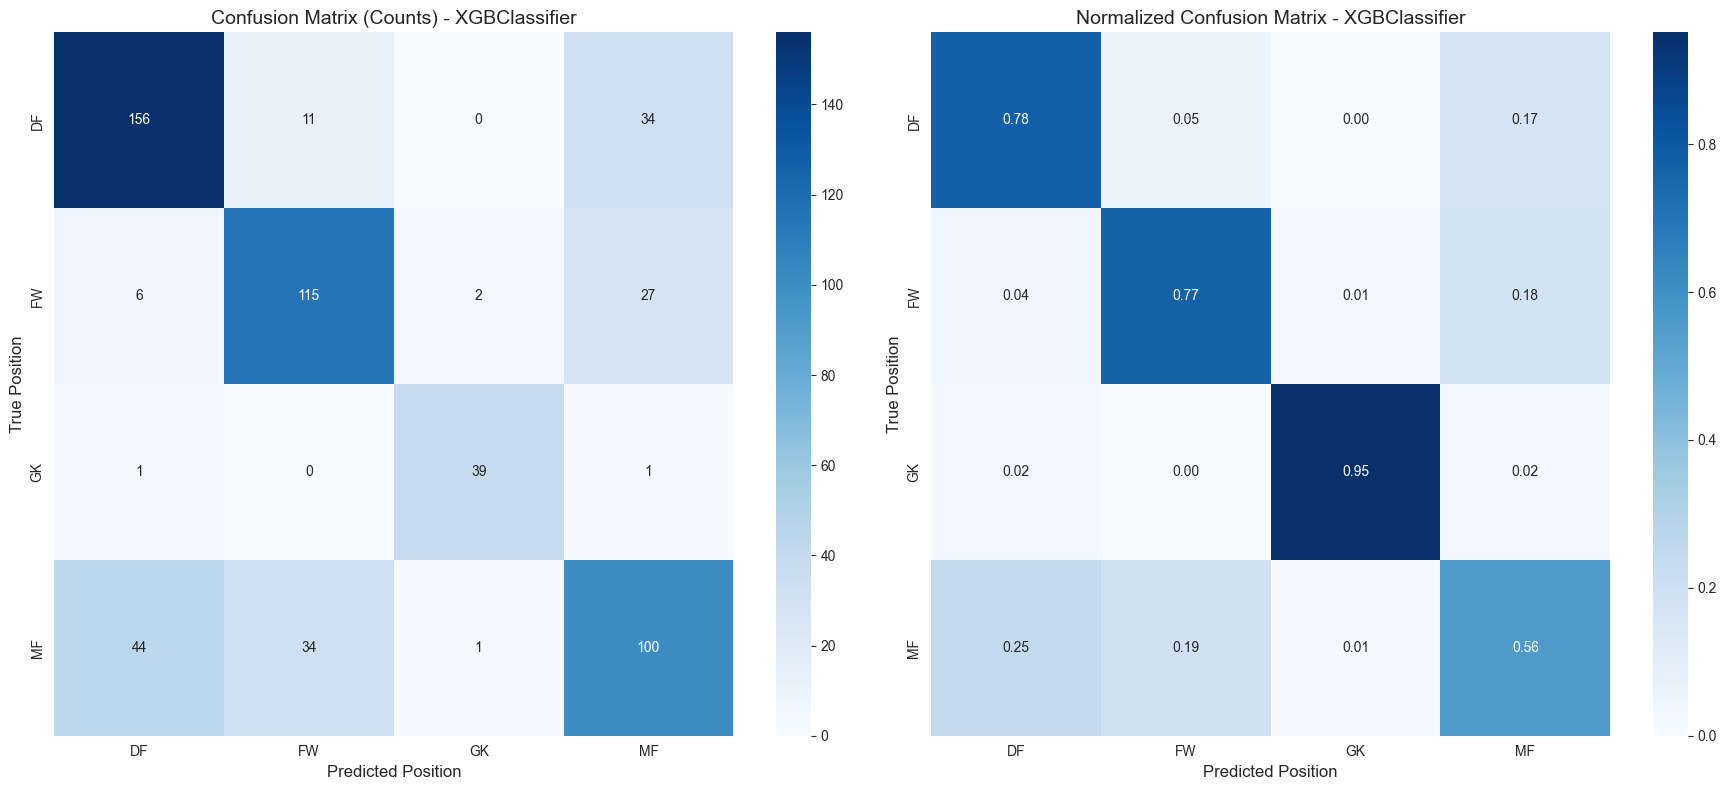

Classification report heatmap saved to artifacts/classification_report_heatmap.png


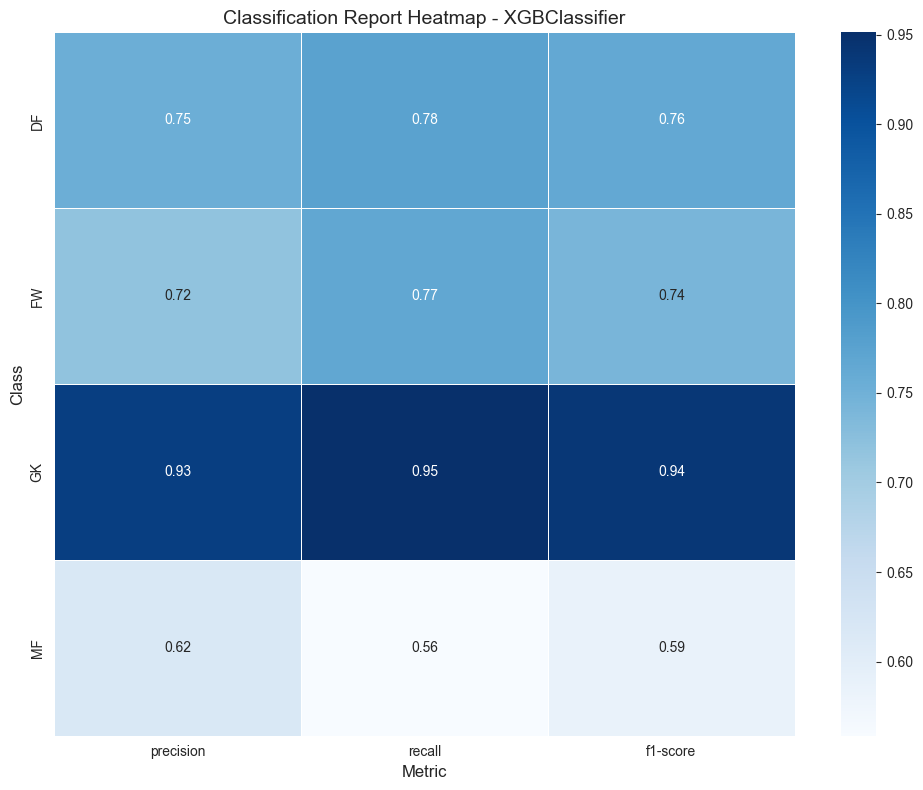

ROC curves saved to artifacts/roc_curves.png


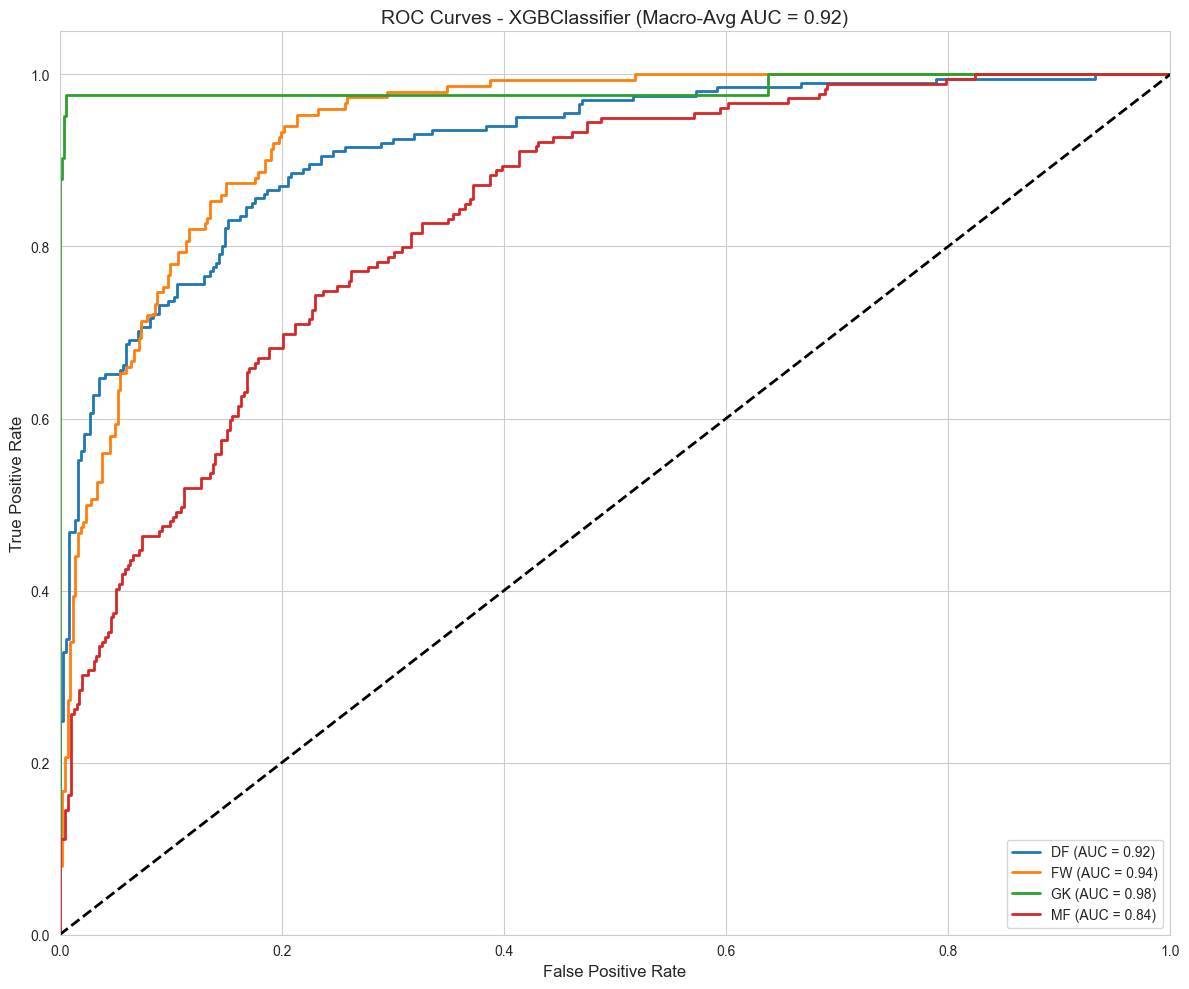

Computing feature importance...

Top 15 features by importance:
            Feature  Importance
              xG_90    0.034015
            npxG_90    0.030336
               PrgR    0.019864
          xG+xAG_90    0.018435
               PrgP    0.015784
        npxG+xAG_90    0.013179
                90s    0.012840
             Starts    0.010226
                Min    0.010188
   Squad_Heidenheim    0.010180
      Nation_cm CMR    0.010110
               PrgC    0.009919
   Squad_Leverkusen    0.009849
        Squad_Lazio    0.009571
Squad_Bayern Munich    0.009201
Feature importance plot saved to artifacts/feature_importance.png


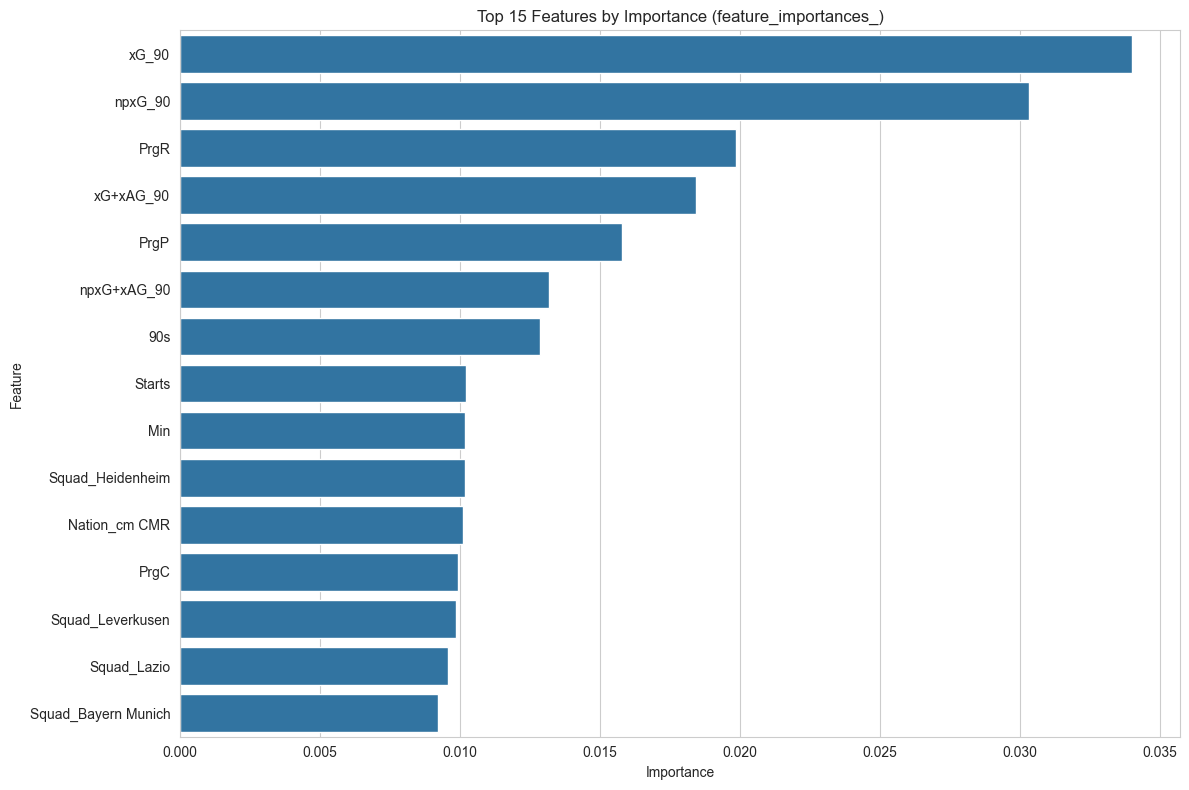

Saving model to artifacts/position_classifier.joblib...
Model saved successfully to artifacts/position_classifier.joblib


In [89]:
# Run the full pipeline in one go
# The following line runs the entire pipeline with a single function call
results = run_full_pipeline('data/top5-players.csv')
